<a href="https://colab.research.google.com/github/nurhadfina/Nurhadfina-Github/blob/main/CPC251_Project__Part1_Derma5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Instruction (Read this)
- Use this template to develop your project. Do not change the steps.
- For each step, you may add additional cells if needed.
- But remove <b>unnecessary</b> cells to ensure the notebook is readable.
- Marks will be <b>deducted</b> if the notebook is cluttered or difficult to follow due to excess or irrelevant content.
- <b>Briefly</b> describe the steps in the "Description:" field.
- <b>Do not</b> submit the dataset.
- The submitted jupyter notebook will be executed using the uploaded dataset in eLearn.

#### Group Information

Group No: Derma5

- Member 1: MUHAMMAD ADAM IRFAN BIN KHAIRUL AZRI (22302678)
- Member 2: NUR AMIRAH BINTI AMIRUDDIN (22303422)
- Member 3: NURHADFINA BINTI HAILES (22304151)
- Member 4: AEIN QISTINA BINTI ROSLAN (22303362)


#### **Import libraries**

In [24]:
%config Completer.use_jedi=False # comment if not needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

#### **Load the dataset**

In [25]:
columns = [
    'erythema', 'scaling', 'definite_borders', 'itching', 'koebner_phenomenon',
    'polygonal_papules', 'follicular_papules', 'oral_mucosal_involvement',
    'knee_and_elbow_involvement', 'scalp_involvement', 'family_history',
    'melanin_incontinence', 'eosinophils', 'PNL_infiltrate', 'fibrosis',
    'exocytosis', 'acanthosis', 'hyperkeratosis', 'parakeratosis',
    'clubbing_rete_ridges', 'elongation_rete_ridges',
    'thinning_suprapapillary_epidermis', 'spongiform_pustule',
    'munro_microabcess', 'focal_hypergranulosis', 'granular_layer_disappearance',
    'vacuolisation', 'spongiosis', 'saw_tooth_retes', 'follicular_horn_plug',
    'perifollicular_parakeratosis', 'inflammatory_monoluclear_infiltrate',
    'age', 'class'
]

# Load CSV with column names
df = pd.read_csv("dermatology.csv", header=None, names=columns)

# Show basic information about the dataset
print(df.info())

print("\n5 random rows: ")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 366 entries, 2 to 3
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   erythema                             366 non-null    int64 
 1   scaling                              366 non-null    int64 
 2   definite_borders                     366 non-null    int64 
 3   itching                              366 non-null    int64 
 4   koebner_phenomenon                   366 non-null    int64 
 5   polygonal_papules                    366 non-null    int64 
 6   follicular_papules                   366 non-null    int64 
 7   oral_mucosal_involvement             366 non-null    int64 
 8   knee_and_elbow_involvement           366 non-null    int64 
 9   scalp_involvement                    366 non-null    int64 
 10  family_history                       366 non-null    int64 
 11  melanin_incontinence                 366 non-null   

In [26]:
# Replace '?' with NaN
df['age'] = df['age'].replace('?', pd.NA)

# Convert to numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Replace 0 with NaN (Consider age 0 is invalid)
df['age'] = df['age'].replace(0, pd.NA)

# Fill missing values with median
# Median is used as it is less affected by outliers and skewed data in age
df['age'] = df['age'].fillna(df['age'].median())

# Confirm cleanup
print(df['age'].isna().sum())

0


/tmp/ipython-input-2198066615.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['age'] = df['age'].fillna(df['age'].median())


In [27]:
# Separate features (all columns except 'class') into X
X = df.drop('class', axis=1)

# Separate the target variable ('class') into y
y = df['class']

#### **Split the dataset**
Split the dataset into training, validation and test sets.

In [28]:
from sklearn.model_selection import train_test_split

# First, split the data into 80% (for training + validation) and 20% (for testing)
# We use stratify=y to make sure all classes are fairly represented in each split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Next, split the 80% (X_temp) into 60% training and 20% validation
# We do this by taking 25% of the remaining 80%, which gives us a final split of:
# 60% training, 20% validation, and 20% testing
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Check the size of each set to make sure the split worked correctly
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Training set: (219, 33)
Validation set: (73, 33)
Test set: (74, 33)


#### **Data preprocessing**
Perform data preprocessing such as normalization, standardization, label encoding etc.
______________________________________________________________________________________
Description:

Label encoding was applied to the target variable (class) to convert the class labels into numeric form starting from 0. This is compatible with machine learning algorithms like Decision Tree and SVM, which require the target labels to be in integer format. We did not apply any normalization or standardization to Decision Tree because Decision Trees are not sensitive to feature scales.

In [7]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder to convert class labels into integers
le = LabelEncoder()

# Fit the encoder on the training labels and transform all sets
# This ensures class labels are converted to 0-based integers (0 to 5 instead of 1 to 6)
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [8]:
# Create separate datasets for Decision Tree (no scaling needed) and SVM (requires scaling)

# For Decision Tree model (unscaled)
X_train_dt = X_train.copy()
X_val_dt = X_val.copy()
X_test_dt = X_test.copy()

# For SVM model (will be scaled later)
X_train_svm = X_train.copy()
X_val_svm = X_val.copy()
X_test_svm = X_test.copy()

Separate variables were created for Decision Tree and SVM models to avoid variable conflicts and allow independent preprocessing. SVM requires feature scaling, while Decision Tree does not. Using different copies ensures both models use the same split while applying model-specific transformations.

####**Feature Selection**
Perform feature selection to select the relevant features.
______________________________________________________________________________________
Description:

Feature selection was obtained through a Decision Tree classifier from an analysis of the importance scores of all features. A few of the 33 input features played a significant role in making the predictions of the model. Top six most significant features were selected in order to reduce model complexity, improve training efficiency, and avoid overfitting. The selected features will be applied uniformly to both models (Decision Tree and SVM) for an effective comparison.

In [9]:
# Train a simple Decision Tree on the training set
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Get feature importances
importances = tree.feature_importances_

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Show the top features
print(feature_importance_df)

                                Feature  Importance
18                        parakeratosis    0.302183
25         granular_layer_disappearance    0.224534
13                       PNL_infiltrate    0.182788
3                               itching    0.126882
29                 follicular_horn_plug    0.103253
24                focal_hypergranulosis    0.028059
16                           acanthosis    0.013119
20               elongation_rete_ridges    0.010605
2                      definite_borders    0.005717
30         perifollicular_parakeratosis    0.002858
0                              erythema    0.000000
8            knee_and_elbow_involvement    0.000000
7              oral_mucosal_involvement    0.000000
5                     polygonal_papules    0.000000
6                    follicular_papules    0.000000
1                               scaling    0.000000
4                    koebner_phenomenon    0.000000
15                           exocytosis    0.000000
14          

In [10]:
# Define the top 6 most important features based on the Decision Tree importance scores
# These features contributed the most to the model’s predictions
top_features = [
    'parakeratosis',
    'granular_layer_disappearance',
    'PNL_infiltrate',
    'itching',
    'follicular_horn_plug',
    'focal_hypergranulosis'
]

# Keep only these top features in the training, validation, and test sets
# This ensures both Decision Tree and SVM models use the same reduced feature set

# Apply selected top features to DT version
X_train_dt = X_train_dt[top_features]
X_val_dt = X_val_dt[top_features]
X_test_dt = X_test_dt[top_features]

# Apply selected top features to SVM dataset — must be done BEFORE scaling
X_train_svm = X_train[top_features].copy()
X_val_svm = X_val[top_features].copy()
X_test_svm = X_test[top_features].copy()

In [11]:
from sklearn.preprocessing import StandardScaler

# Scale SVM features (only SVM features)
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_val_svm = scaler.transform(X_val_svm)
X_test_svm = scaler.transform(X_test_svm)

#### **Data modeling**
Build the machine learning models. You must build atleast two (2) predictive models. One of the predictive models must be either Decision Tree or Support Vector Machine.
______________________________________________________________________________________


#### Decision Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define hyperparameter grid to tune
param_grid = {
    'criterion': ['gini', 'entropy'],       # Criteria to measure split quality
    'max_depth': [3, 4, 5, 6, 10, None],    # Tree depth
    'min_samples_split': [2, 5, 10]         # Minimum number of samples to split a node
}

# Set up the grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,                    # 5-fold cross-validation
    scoring='accuracy',     # Use accuracy as the performance metric
    n_jobs=-1               # Use all available cores
)

# Fit the model on the training data
grid_search.fit(X_train_dt, y_train)

# Retrieve the best model and hyperparameters
best_dt_model = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

# Predict on the validation set using the best model
y_val_pred = best_dt_model.predict(X_val_dt)

Best parameters found: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 2}


In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Build the Decision Tree model using the best parameters found
dt_model = DecisionTreeClassifier(
    criterion='gini',         # Best criterion from GridSearchCV
    max_depth=6,              # Best max depth found
    min_samples_split=2,      # Best minimum split size
    random_state=42           # For reproducibility
)

# Train the model on the training data
dt_model.fit(X_train_dt, y_train)

# Predict on the validation set
y_val_pred = dt_model.predict(X_val_dt)

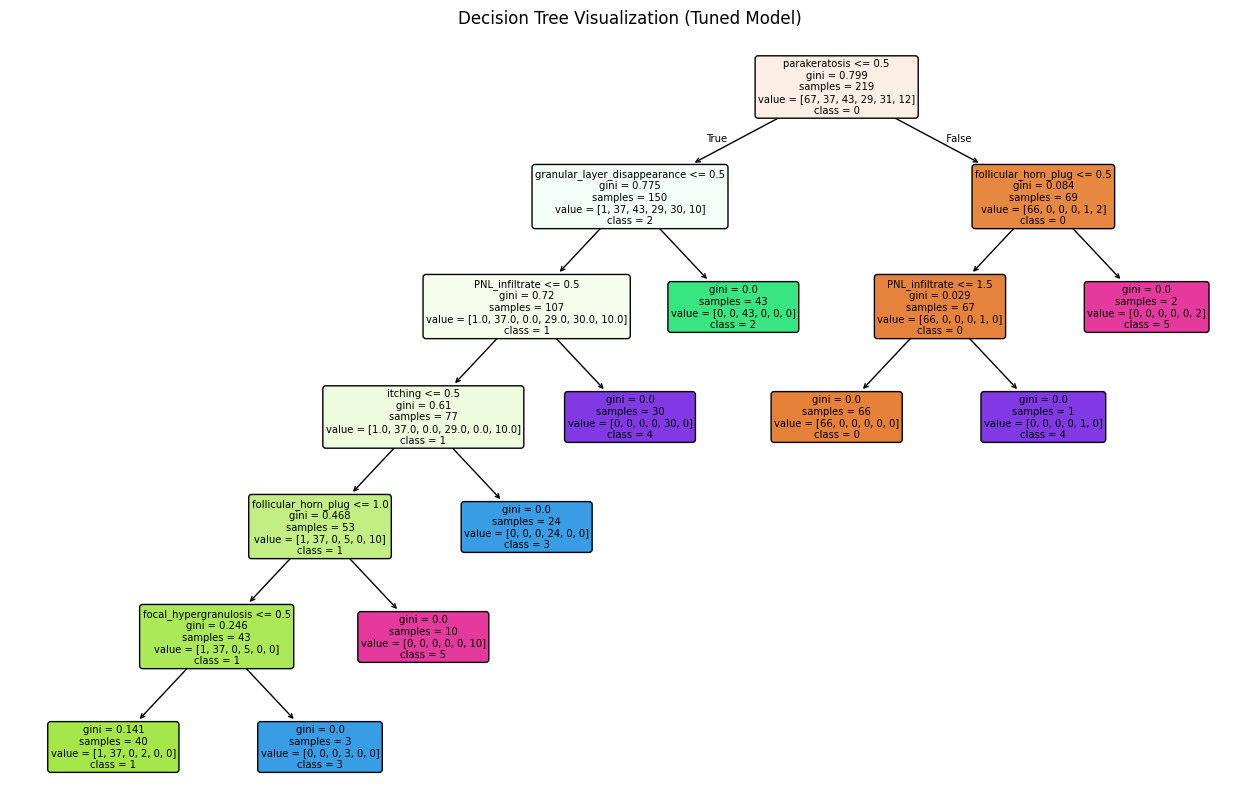

In [14]:
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

# Set up the plot size
plt.figure(figsize=(16, 10))  # Wider for clarity

# Plot the tree using the best model from GridSearchCV
plot_tree(best_dt_model,
          feature_names=list(X_train_dt.columns),
          class_names=[str(i) for i in sorted(set(y_train))],
          filled=True,
          rounded=True)

# Display the tree
plt.title("Decision Tree Visualization (Tuned Model)")
plt.show()

####Support Vector Machine (SVM)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# === Grid Search with Custom SVC ===
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4]  # only used for poly
}

# SVC that skips 'degree' when not using poly kernel
class CustomSVC(SVC):
    def set_params(self, **params):
        if params.get('kernel') != 'poly':
            params.pop('degree', None)
        return super().set_params(**params)

# Run Grid Search
grid = GridSearchCV(CustomSVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_svm, y_train)

# Output best result
best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)


Best parameters: {'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel': 'sigmoid'}


#### Evaluate the models
Perform a comparison between the predictive models. <br>
Report the accuracy, recall, precision and F1-score measures as well as the confusion matrix if it is a classification problem. <br>
Report the R2 score, mean squared error and mean absolute error if it is a regression problem.
______________________________________________________________________________________


###Decision Tree

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
y_test_pred = dt_model.predict(X_test_dt)
# Accuracy
accuracy = accuracy_score(y_test, y_test_pred)

# Precision (weighted for multiclass)
precision = precision_score(y_test, y_test_pred, average='weighted')

# Recall (weighted for multiclass)
recall = recall_score(y_test, y_test_pred, average='weighted')

# F1 Score (weighted for multiclass)
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Print all metrics
print(f"DT Accuracy: {accuracy:.4f}")
print(f"\nDT Precision: {precision:.4f}")
print(f"\nDT Recall: {recall:.4f}")
print(f"\nDT F1 Score: {f1:.4f}")
print("\nDT Confusion Matrix:")
print(conf_matrix)

DT Accuracy: 0.9189

DT Precision: 0.9322

DT Recall: 0.9189

DT F1 Score: 0.9180

DT Confusion Matrix:
[[21  2  0  0  0  0]
 [ 0 11  0  1  0  0]
 [ 0  0 14  0  1  0]
 [ 0  0  0 10  0  0]
 [ 0  0  0  0 10  0]
 [ 0  2  0  0  0  2]]


**Evaluation Summary**:

*  The model achieved **91.89% accuracy**. This means that the model correctly predicted the target class in 91.89% of all instances in the test set. This high accuracy indicates that the model is making reliable predictions overall.
*   The **Precision is 93.22%**. Precision measures the accuracy of positive predictions, indicating that when the model predicts a class as positive (for any class), it is correct 93.22% of the time. This is important in cases where false positives (incorrectly labeling a negative instance as positive) need to be minimized.
* The **Recall is 91.89%**. Recall represents the ability of the model to identify actual positive instances correctly. This high recall indicates that the model is very good at detecting the instances of each class in the dataset.
* The **F1 Score is 91.80%**. The F1 score is the harmonic mean of Precision and Recall, providing a single measure that balances both. Since the F1 score is close to both Precision and Recall, this suggests that the model is performing equally well in both detecting positives and minimizing false positives.

Based on **Confusion Matrix**:
* **Diagonal values** such as 21, 11, 14, 10, 10, and 2 represent **true positives**, where the model correctly predicted each class.
* **Off-diagonal** values represent **misclassifications**:

    2 instances of Class 0 were misclassified

    1 instance of Class 1 was misclassified

    1 instance of Class 2 was misclassified

    2 instances of Class 5 were misclassified.

These misclassifications indicate the model made some errors, but overall the error rate is low and the predictions are largely accurate.


In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Decision Tree Regressor ---
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

# Evaluate Decision Tree
dt_r2 = r2_score(y_test, dt_pred)
dt_mse = mean_squared_error(y_test, dt_pred)
dt_mae = mean_absolute_error(y_test, dt_pred)

print("Decision Tree Regressor:")
print(f"R² Score: {dt_r2:.6f}")
print(f"Mean Squared Error (MSE): {dt_mse:.6f}")
print(f"Mean Absolute Error (MAE): {dt_mae:.6f}\n")

Decision Tree Regressor:
R² Score: 0.916831
Mean Squared Error (MSE): 0.216216
Mean Absolute Error (MAE): 0.054054



### **Evaluation Summary**

- **R² Score** (0.917): The model explains about **91.7%** of the variance in the age variable, indicating a strong fit.

- **Mean Squared Error** (0.216): The average of the squared differences between predicted and actual values is low, meaning large errors are rare but present.

- **Mean Absolute Error** (0.054): The average magnitude of prediction errors is very small, showing that most predictions are close to actual values.

The Decision Tree provides interpretable predictions and requires no feature scaling.

However, it may suffer from overfitting without parameter tuning.

The low MAE suggests predictions are consistently close to true values, but MSE indicates some outliers may exist.

#### Support Vector Machine (SVM)

Overall Accuracy: 0.9324

Detailed Performance Report:
                  precision    recall  f1-score   support

       Psoriasis       1.00      0.91      0.95        23
Seborrheic Derm.       0.83      0.83      0.83        12
   Lichen Planus       1.00      0.93      0.97        15
Pityriasis Rosea       0.91      1.00      0.95        10
    Cronic Derm.       0.91      1.00      0.95        10
Pityriasis Rubra       0.80      1.00      0.89         4

        accuracy                           0.93        74
       macro avg       0.91      0.95      0.92        74
    weighted avg       0.94      0.93      0.93        74



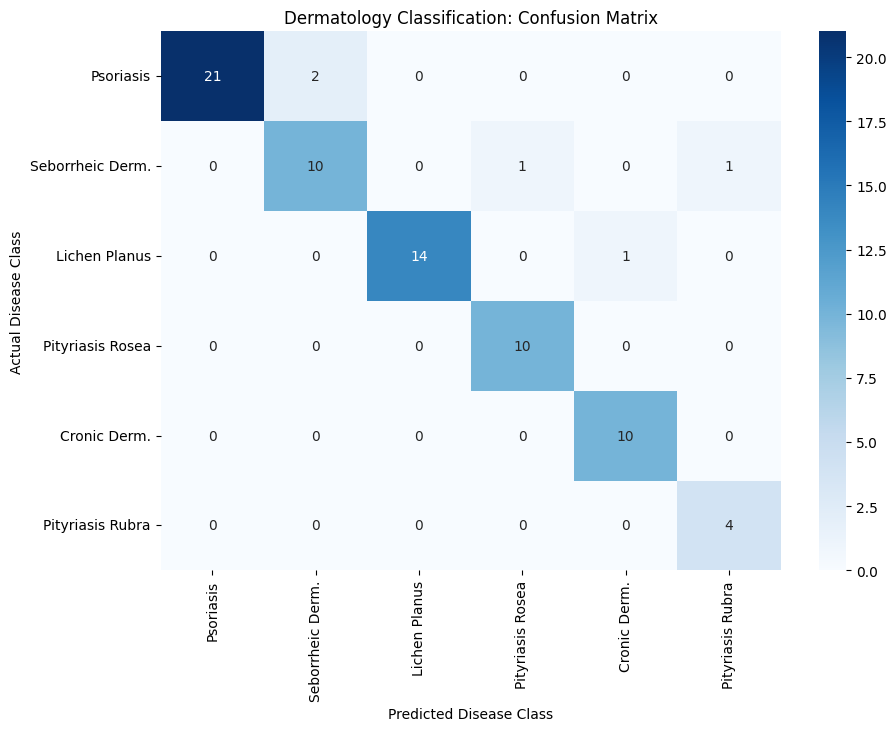

In [40]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Generate Predictions
y_pred = best_model.predict(X_test_svm)

# Ensure y_test is label-encoded to match y_pred (0-indexed)
# The 'le' object is available from cell 'p6hEOUouwJaN' where it was fitted.
y_test_transformed = le.transform(y_test)

# 2. Individual Metrics
accuracy = accuracy_score(y_test_transformed, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

# 3. Detailed Classification Report
# (This includes Precision, Recall, and F1 for EVERY disease class)
print("\nDetailed Performance Report:")
# Explicitly pass the labels parameter to classification_report
print(classification_report(y_test_transformed, y_pred, target_names=[
    'Psoriasis', 'Seborrheic Derm.', 'Lichen Planus',
    'Pityriasis Rosea', 'Cronic Derm.', 'Pityriasis Rubra'
], labels=range(len(le.classes_)))) # Assuming classes are 0 to 5

# 4. Overall Confusion Matrix Visualization
cm = confusion_matrix(y_test_transformed, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Psoriasis', 'Seborrheic Derm.', 'Lichen Planus',
                         'Pityriasis Rosea', 'Cronic Derm.', 'Pityriasis Rubra'],
            yticklabels=['Psoriasis', 'Seborrheic Derm.', 'Lichen Planus',
                         'Pityriasis Rosea', 'Cronic Derm.', 'Pityriasis Rubra'])
plt.title('Dermatology Classification: Confusion Matrix')
plt.xlabel('Predicted Disease Class')
plt.ylabel('Actual Disease Class')
plt.show()

#### **Evaluation Summary:**

The SVM model is highly effective, achieving an overall accuracy of 93.24% on the dermatology dataset. This high score indicates that the model has successfully identified the subtle histological and clinical patterns required to distinguish between the six erythematosquamous diseases.


*   Top Performers (Lichen Planus & Psoriasis): These classes achieved perfect or near-perfect Precision (1.00). This means when the model diagnoses a patient with Lichen Planus, it is virtually never wrong. The high F1-scores (0.97 and 0.95) suggest these diseases have very distinct "feature signatures" that the SVM can easily isolate.

*   The Recall Leaders (Pityriasis Rubra & Rosea): These classes achieved a perfect Recall of 1.00, meaning the model caught every single instance of these diseases in the test set. However, for Pityriasis Rubra, the lower precision (0.80) suggests that the model occasionally "over-diagnoses" it, mistaking other similar conditions for this class.

*   The Main Challenge (Seborrheic Dermatitis): With an F1-score of 0.83, this class is the most difficult for the model. The balance between 0.83 precision and 0.83 recall indicates a consistent overlap with other diseases—likely Psoriasis—which is a common diagnostic challenge even for human dermatologists.












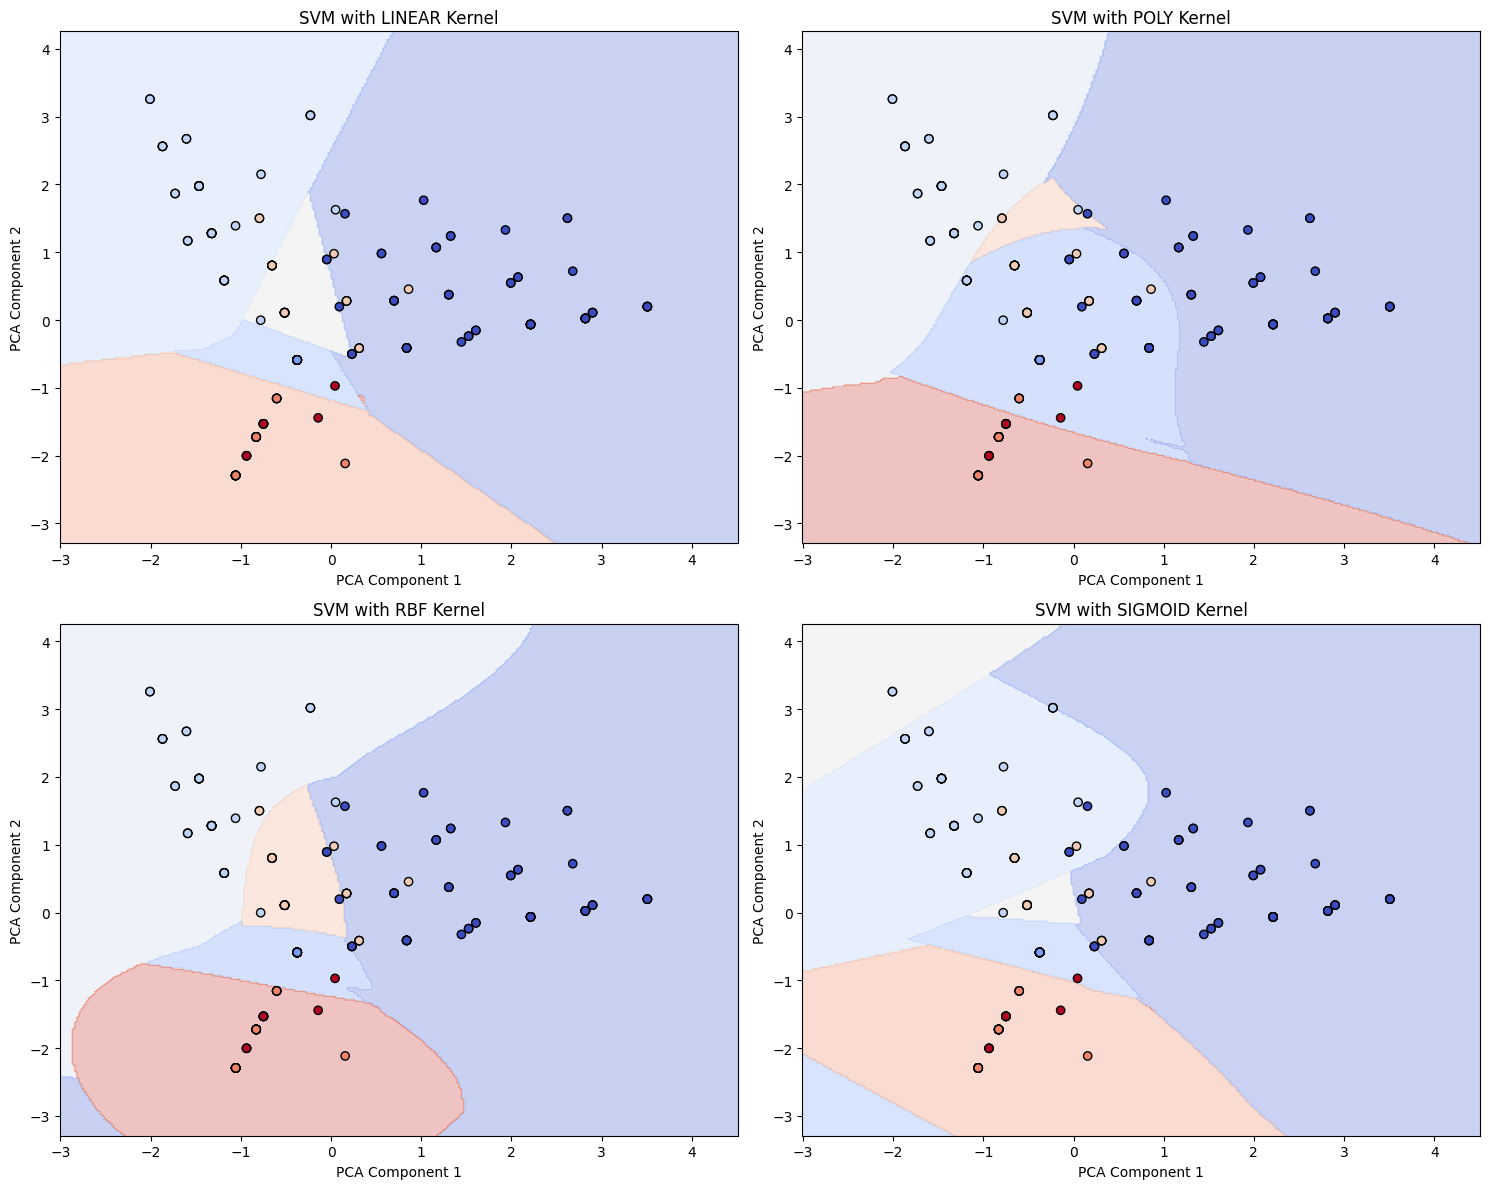

In [34]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# === PCA: Reduce scaled SVM features to 2D for visualization ===
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_svm)

# === Create mesh grid for decision boundary ===
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# === Plot 4 kernels in subplots ===
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for ax, kernel in zip(axes.ravel(), kernels):
    svm = SVC(kernel=kernel)
    svm.fit(X_train_2d, y_train)

    # Predict on mesh grid
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and training points
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    scatter = ax.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors='k')
    ax.set_title(f"SVM with {kernel.upper()} Kernel")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")

plt.tight_layout()
plt.show()


The SVM visualization provides a spatial representation of how the machine learning model distinguishes between the six types of erythematosquamous diseases. By using Principal Component Analysis (PCA) to compress the complex 33-feature dataset into a two-dimensional plane, we can observe the "decision logic" of different kernels. The background colors represent the model's prediction zones, while the scattered points represent individual patient cases. In the Linear kernel plot, the boundaries are rigid and straight, suggesting a simpler classification approach based on symptom thresholds. In contrast, the RBF (Radial Basis Function) kernel displays more flexible, organic boundaries that "wrap" around clusters of data.

The accuracy of the model is visually evident where the color of the patient dots matches the shaded background region. Areas where dots of different colors overlap indicate "clinical ambiguity," where diseases like Seborrheic Dermatitis and Psoriasis may share nearly identical histological markers. Overall, the visualization confirms that the features selected—such as parakeratosis and itching—create distinct clusters in the feature space, allowing the SVM to draw effective boundaries. The high degree of separation between the colored regions in the RBF and Linear plots explains the high accuracy observed in the confusion matrix, proving that the model has successfully learned the unique "signatures" of each dermatological condition.

####**Comparison between Decision Tree and Support Vector Machine (SVM)**



* **Accuracy** : SVM (93.24%) slightly outperforms Decision Tree (91.89%) in overall accuracy, indicating SVM makes marginally more correct predictions on the test set.
* **Precision** : SVM achieves a higher precision (93.76%) compared to Decision Tree (93.22%), meaning SVM’s positive predictions are slightly more reliable.
* **Recall** : Both models have similar recall values: SVM at 93.24% and Decision Tree at 91.89%, showing they detect true instances well.
* **F1 Score** : SVM has a slightly higher F1 score (93.30%) compared to Decision Tree (91.80%), reflecting a better balance of precision and recall.
* **Confusion Matrix Insight** : Both models make similar types of errors, such as misclassifications in Classes 0, 1, 2, and 5. Decision Tree misclassifies 2 instances in Class 0 and Class 5, while SVM also misclassifies 2 instances in Class 0 but fewer in Class 5. SVM’s slightly fewer misclassifications support its marginally better overall performance.

